In [1]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from fuzzywuzzy import fuzz
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Embedding, LSTM,Dropout,Bidirectional,GlobalMaxPooling1D

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [1]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# load dataset

In [2]:
data = pd.read_csv('Bot Dataset(fixed).csv')
data.tail()

,tag,Question,Answer
430,user 438,Saya merasa bersalah karena saya tidak mengata...,"Hai Tennessee, tidak ada yang salah dengan And..."
431,user 439,Bagaimana cara mengatasi pikiran buruk?,Kedengarannya Anda merasa sangat kewalahan den...
432,user 440,Bagaimana saya bisa merasa begitu kosong meski...,Apakah ada saat atau momen di mana Anda merasa...
433,user 441,Saya pikir saya memiliki kecemasan dan depresi...,Anda mungkin menekan diri untuk menjadi satu -...
434,user 442,Saya memiliki suara di kepala saya,Karena Anda menyadari bahwa mendengar suara -s...


# inisialisasi stop words

In [3]:
stopwords = []
with open('stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

In [4]:
# fungsi untuk menghilangkan stopwords
def remove_stopwords(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    temp = re.sub(r'[.,’"\'-?:!;]', '', text)
    text = re.sub(r'^Apa|^Saya|^Aku|^maukah|^Siapa|^Bagaimana|^Dimana|^Kapan|^Kenapa|^Bisakah', '', text)
    words = [word for word in text.split() if word not in stopwords]
    return ' '.join(words)

In [5]:
# menghilangkan stopwords dari dataset
data['Question'] = data['Question'].apply(remove_stopwords)
print(data['Question'])

0                                        penyakit mental
1                           mempengaruhi penyakit mental
2                            menyebabkan penyakit mental
3                 tanda tanda peringatan penyakit mental
4                            orang penyakit mental pulih
                             ...                        
430                               bersalah kemajuan pria
431                              mengatasi pikiran buruk
432                                        kosong remaja
433    pikir memiliki kecemasan depresi memanifestasi...
434                                memiliki suara kepala
Name: Question, Length: 435, dtype: object


# inisialisasi tokenizer

In [6]:
# inisialisasi tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['Question'])

In [7]:
# fungsi untuk mengganti kata typo dengan kata yang paling mirip pada dataset
def correct_typo(word):
    max_score = -1
    correct_word = word
    for vocab_word in tokenizer.word_index:
        score = fuzz.ratio(word, vocab_word)
        if score > max_score:
            max_score = score
            correct_word = vocab_word
    return correct_word

# fungsi untuk mengoreksi typo pada kalimat
def correct_sentence(sentence):
    corrected_sentence = []
    words = sentence.split()
    for word in words:
        corrected_word = correct_typo(word)
        corrected_sentence.append(corrected_word)
    return ' '.join(corrected_sentence)

# fungsi untuk membersihkan dan memproses input pengguna
def preprocess_input(text):
    text = remove_stopwords(text)
    text = correct_sentence(text)
    return text


# encoding label Respon

In [8]:
encoder = LabelEncoder()
encoder.fit(data['Answer'])
encoded_labels = encoder.transform(data['Answer'])

# split data menjadi train dan validation set

In [9]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
val_data = data[train_size:]

train_seq = tokenizer.texts_to_sequences(data['Question'])
val_seq = tokenizer.texts_to_sequences(val_data['Question'])

train_label_seq = encoded_labels[:train_size]
val_label_seq = encoded_labels[train_size:]

# padding sequence

In [10]:
train_seq = pad_sequences(train_seq, maxlen=100, truncating='post')
val_seq = pad_sequences(val_seq, maxlen=100, truncating='post')

# callback

In [11]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.998:
            print("\n\nAccuracy Has Been Achieved Around 99.8%, Training Stop!\n")
            self.model.stop_training = True

# MODEL

In [14]:
model = Sequential([
    Embedding(len(tokenizer.word_index)+1, 64, input_length=100),
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(450, activation='softmax')
])
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [15]:
# training model
history = model.fit(train_seq, encoded_labels, epochs=200,callbacks=[Callback()])

Epoch 1/200
14/14 [==============================] - 14s 414ms/step - loss: 6.1155 - accuracy: 0.0023
Epoch 2/200
14/14 [==============================] - 6s 401ms/step - loss: 6.1056 - accuracy: 0.0069
Epoch 3/200
14/14 [==============================] - 6s 395ms/step - loss: 6.0974 - accuracy: 0.0115
Epoch 4/200
14/14 [==============================] - 7s 505ms/step - loss: 6.1019 - accuracy: 0.0115
Epoch 5/200
14/14 [==============================] - 6s 440ms/step - loss: 6.0443 - accuracy: 0.0161
Epoch 6/200
14/14 [==============================] - 6s 438ms/step - loss: 6.0150 - accuracy: 0.0115
Epoch 7/200
14/14 [==============================] - 7s 478ms/step - loss: 5.9868 - accuracy: 0.0115
Epoch 8/200
14/14 [==============================] - 6s 442ms/step - loss: 5.9557 - accuracy: 0.0115
Epoch 9/200
14/14 [==============================] - 7s 481ms/step - loss: 5.9246 - accuracy: 0.0115
Epoch 10/200
14/14 [==============================] - 6s 465ms/step - loss: 5.8321 - accur

14/14 [==============================] - 5s 379ms/step - loss: 0.3917 - accuracy: 0.8253
Epoch 82/200
14/14 [==============================] - 5s 382ms/step - loss: 0.3859 - accuracy: 0.8345
Epoch 83/200
14/14 [==============================] - 6s 391ms/step - loss: 0.3902 - accuracy: 0.8414
Epoch 84/200
14/14 [==============================] - 5s 378ms/step - loss: 0.3717 - accuracy: 0.8184
Epoch 85/200
14/14 [==============================] - 6s 430ms/step - loss: 0.4202 - accuracy: 0.8161
Epoch 86/200
14/14 [==============================] - 5s 379ms/step - loss: 0.3819 - accuracy: 0.8368
Epoch 87/200
14/14 [==============================] - 5s 379ms/step - loss: 0.3802 - accuracy: 0.8299
Epoch 88/200
14/14 [==============================] - 5s 379ms/step - loss: 0.3913 - accuracy: 0.8230
Epoch 89/200
14/14 [==============================] - 5s 384ms/step - loss: 0.3694 - accuracy: 0.8276
Epoch 90/200
14/14 [==============================] - 5s 386ms/step - loss: 0.3809 - accuracy: 

14/14 [==============================] - 5s 384ms/step - loss: 0.3394 - accuracy: 0.8253
Epoch 161/200
14/14 [==============================] - 5s 378ms/step - loss: 0.3354 - accuracy: 0.8207
Epoch 162/200
14/14 [==============================] - 5s 382ms/step - loss: 0.3359 - accuracy: 0.8207
Epoch 163/200
14/14 [==============================] - 5s 381ms/step - loss: 0.3505 - accuracy: 0.8322
Epoch 164/200
14/14 [==============================] - 5s 382ms/step - loss: 0.3456 - accuracy: 0.8391
Epoch 165/200
14/14 [==============================] - 5s 382ms/step - loss: 0.3244 - accuracy: 0.8299
Epoch 166/200
14/14 [==============================] - 6s 463ms/step - loss: 0.3304 - accuracy: 0.8253
Epoch 167/200
14/14 [==============================] - 7s 485ms/step - loss: 0.3385 - accuracy: 0.8207
Epoch 168/200
14/14 [==============================] - 7s 494ms/step - loss: 0.3423 - accuracy: 0.8299
Epoch 169/200
14/14 [==============================] - 7s 506ms/step - loss: 0.3447 - a

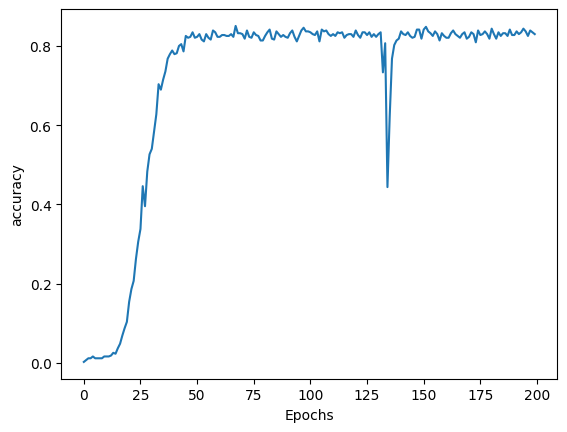

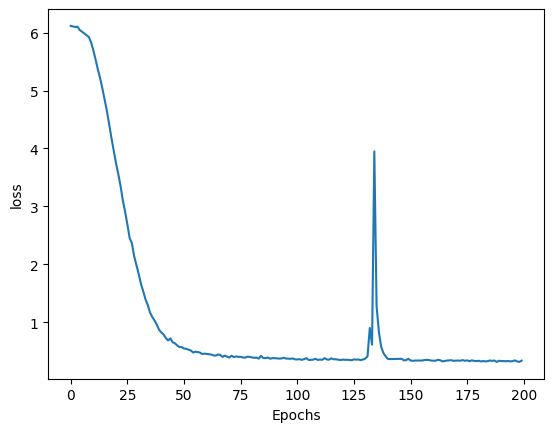

In [16]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# TESTING

In [20]:
try:
    input_text = input('Masukkan pertanyaan: ')
    preprocessed_text = preprocess_input(input_text)
    input_seq = tokenizer.texts_to_sequences([preprocessed_text])
    input_seq = pad_sequences(input_seq, maxlen=100)
    predicted_label_seq = model.predict(input_seq)
    predicted_label = encoder.inverse_transform(predicted_label_seq.argmax(axis=-1))[0]
    print('Bot: ', predicted_label)
except:
    print("Bot : maaf saya tidak memahami maksud anda")

Masukkan pertanyaan: saya pikir saya jelek
1/1 [==============================] - 0s 42ms/step
Bot:  Nah, apakah Anda benar-benar berpikir begitu? Apakah Anda ingin melihat wajah paling cantik yang pernah ada? Buka WebCam Anda dan voila, wajah tercantik di planet ini muncul secara ajaib.


# save model

In [21]:
#model.save("model.h5")

In [22]:

#import pickle
#with open('tokenizer.pickle', 'wb') as handle:
     #pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('label_encoder.pickle', 'wb') as f:
     #pickle.dump(encoder, f, protocol=pickle.HIGHEST_PROTOCOL)